In [43]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as constants
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [44]:
def xy_2_idx(x, y, Ly):

    return x * Ly + y


def idx_2_xy(idx:int, Lx:int, Ly:int) -> (int, int):

    return idx // Ly, idx % Ly


def create_bond_indices(Lx:int, Ly:int) -> np.ndarray:
    
    horizontal_bond_indices, vertical_bond_indices = [], []
    for x in range(Lx):
        for y in range(Ly):
            horizontal_bond_indices.append([xy_2_idx(x, y, Ly), xy_2_idx(x, (y + 1) % Ly, Ly)])
            vertical_bond_indices.append([xy_2_idx(x, y, Ly), xy_2_idx((x + 1) % Lx, y, Ly)])

    bond_indices = np.array(horizontal_bond_indices + vertical_bond_indices)
    
    return bond_indices

In [45]:
def update_bond_config(spin_config:np.ndarray, bond_indices:np.ndarray, T:float) -> np.ndarray:

    bond_config = spin_config[bond_indices].sum(axis=1)
    (parallel_spin_indices,) = np.where(bond_config != 0)
    bond_config[parallel_spin_indices] = (np.random.random(size=len(parallel_spin_indices)) > np.exp(-2/T)).astype(int)
    
    return bond_config

In [46]:
def swendsen_wang_update(spin_config, bond_indices, T):

    bond_config = update_bond_config(spin_config, bond_indices, T)
    
    N = len(spin_config)
    graph = csr_matrix((bond_config, (bond_indices[:, 0], bond_indices[:, 1])), shape=(N, N))
    graph += graph.transpose() # Create a symmetric graph
    n_clusters, clusters = connected_components(csgraph=graph, directed=False, return_labels=True)
    
    (flipping_clusters, ) = np.where(np.random.random(n_clusters) > 1/2)
    spin_config[np.isin(clusters, flipping_clusters)] *= -1

    return spin_config

In [47]:
def measure_energy(spin_config, bond_indices):

    return -1. / len(spin_config) * np.prod(spin_config[bond_indices], axis=1).sum()


def measure_magnetization(spin_config):
    
    return spin_config.sum() / len(spin_config)

In [48]:
def mc_simulation(T, Lx, Ly, N_sweeps, N_eq, N_flips):
    
    if N_eq is None:
        N_eq = N_sweeps//10

    bond_indices = create_bond_indices(Lx, Ly)

    spin_config = np.random.choice([-1, 1], size=Lx*Ly)
    E_list, M_list = [], []
    for step in range(N_sweeps + N_eq):

        spin_config = swendsen_wang_update(spin_config, bond_indices, T)
        if step >= N_eq and np.mod(step, N_flips) == 0:
            E_list.append(measure_energy(spin_config, bond_indices))
            M_list.append(measure_magnetization(spin_config))

    return np.array(E_list), np.array(M_list)

In [49]:
def run(T_list, Lx_list, Ly_list, N_sweeps, N_eq=None, N_flips=10):

    E_data, M_data = [], []
    for Lx, Ly in zip(Lx_list, Ly_list):

        E_mean_list, M_mean_list = [], []
        for T in T_list:
            E_list, M_list = mc_simulation(T, Lx, Ly, N_sweeps, N_eq, N_flips)
            E_mean_list.append(E_list.mean())
            M_mean_list.append(M_list.mean())

        E_data.append(E_mean_list), M_data.append(M_mean_list)

    return np.array(E_data), np.array(M_data)

In [50]:
T_list = np.linspace(2.7, 1.7, 40)
Lx_list = [4, 8, 16]
Ly_list = Lx_list

N_sweeps = 1000
N_eq = None
N_flips = 10

E_data, M_data = run(T_list, Lx_list, Ly_list, N_sweeps, N_eq, N_flips)

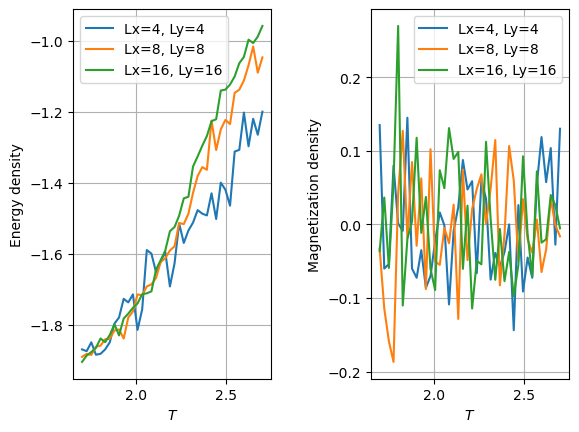

In [51]:
fig, (ax0, ax1) = plt.subplots(1, 2)
for i, (Lx, Ly) in enumerate(zip(Lx_list, Ly_list)):
    
    ax0.plot(T_list, E_data[i], '-', label="Lx=%d, Ly=%d"%(Lx, Ly))
    ax1.plot(T_list, M_data[i], '-', label="Lx=%d, Ly=%d"%(Lx, Ly))

ax0.set_xlabel("$T$")
ax1.set_xlabel("$T$")
ax0.set_ylabel("Energy density")
ax1.set_ylabel("Magnetization density")
ax0.grid()
ax1.grid()
ax0.legend()
ax1.legend()
fig.subplots_adjust(wspace=0.5)

**Auto-correlation**

In [52]:
def auto_correlation(x, δ):

    n = len(x)
    C = np.array([x[δ:][j] * x[j] for j in range(n-δ)]).sum() / (n-δ)
    C -= x.mean()**2
    C /= x.var()
    
    return C

In [108]:
T_list = [1, 2.3, 10]
Lx, Ly = 4, 4

N_sweeps = 10000
N_eq = None
N_flips = 1

δ_list = np.arange(1, int(N_sweeps/100))

E_corr_data, M_corr_data = [], []
for T in T_list:

    E_list, M_list = mc_simulation(T, Lx, Ly, N_sweeps, N_eq, N_flips)

    E_corr_list, M_corr_list = [], []
    for δ in δ_list:
        E_corr_list.append(auto_correlation(E_list, δ))
        M_corr_list.append(auto_correlation(M_list, δ))

    E_corr_data.append(E_corr_list), M_corr_data.append(M_corr_list)

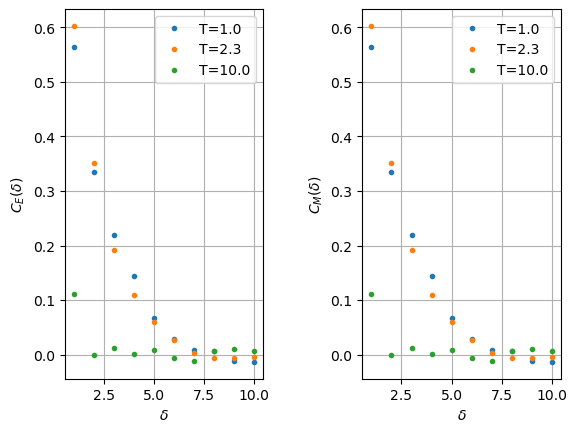

In [109]:
fig, (ax0, ax1) = plt.subplots(1, 2)
for i, T in enumerate(T_list):
    
    ax0.plot(δ_list[:10], E_corr_data[i][:10], '.', label="T=%.1f"%T)
    ax1.plot(δ_list[:10], E_corr_data[i][:10], '.', label="T=%.1f"%T)

ax0.set_xlabel("$\delta$")
ax1.set_xlabel("$\delta$")
ax0.set_ylabel("$C_{E}(\delta)$")
ax1.set_ylabel("$C_{M}(\delta)$")
ax0.grid()
ax1.grid()
ax0.legend()
ax1.legend()
fig.subplots_adjust(wspace=0.5)

#ax0.set_yscale('log')

In [110]:
import metropolis

In [111]:
def metropolis_loop(system, T, N_sweeps, N_eq, N_flips):
    """ Main loop doing the Metropolis algorithm."""
    if N_eq is None:
        N_eq = N_sweeps//10
        
    M = np.sum(system)   # this is new
    E = metropolis.measure_energy(system)  # the "measure_energy" is defined in metropolis
    L = system.shape[0]
    E_list = []
    M_list = []  # this is new
    for step in range(N_sweeps + N_eq):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        dE = -2. * metropolis.energy(system, i, j, L)
        if dE <= 0.:
            system[i, j] *= -1
            E += dE
            M += 2*system[i,j]  # this is new
        elif np.exp(-1. / T * dE) > np.random.rand():
            system[i, j] *= -1
            E += dE
            M += 2*system[i,j]  # this is new

        if step >= N_eq and np.mod(step, N_flips) == 0:
            # measurement
            E_list.append(E)
            M_list.append(M)
    assert(M == np.sum(system)) # (error check, can be ommited)
    return np.array(E_list), np.array(M_list)

In [112]:
T_list = [1, 2.3, 10]
L = Lx
system = metropolis.prepare_system(L)

N_sweeps = 10000 #Lx*Ly
N_eq = None
N_flips = 1

δ_list = np.arange(1, int(N_sweeps/100))

E_corr_data, M_corr_data = [], []
for T in T_list:

    E_list, M_list = E_list, M_list = metropolis_loop(system, T, N_sweeps, N_eq, N_flips)

    E_corr_list, M_corr_list = [], []
    for δ in δ_list:
        E_corr_list.append(auto_correlation(E_list, δ))
        M_corr_list.append(auto_correlation(M_list, δ))

    E_corr_data.append(E_corr_list), M_corr_data.append(M_corr_list)

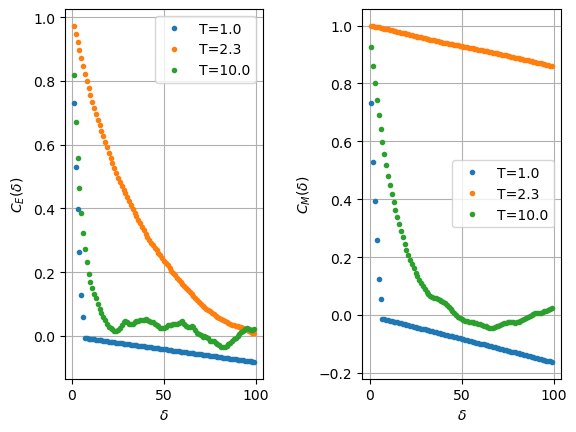

In [113]:
fig, (ax0, ax1) = plt.subplots(1, 2)
for i, T in enumerate(T_list):
    
    ax0.plot(δ_list[:100], E_corr_data[i][:100], '.', label="T=%.1f"%T)
    ax1.plot(δ_list[:100], M_corr_data[i][:100], '.', label="T=%.1f"%T)

ax0.set_xlabel("$\delta$")
ax1.set_xlabel("$\delta$")
ax0.set_ylabel("$C_{E}(\delta)$")
ax1.set_ylabel("$C_{M}(\delta)$")
ax0.grid()
ax1.grid()
ax0.legend()
ax1.legend()
fig.subplots_adjust(wspace=0.5)

Cleary, the correlation time is much larger for the local Metropolis algorithm compared to the global Swendsen-Wang algorithm (cf. above)